In [1]:
import os
import imutils
import dlib
import skimage
import math
import pytesseract
import argparse
import warnings

import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from PIL import Image
from shutil import copy
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
#from face_verification.api import *
#from face_verification.utils import *
#from .utils import read_image, BGR2RGB, BGR2Gray, crop_face
#from .facenet import triplet_loss

%matplotlib inline
warnings.simplefilter('ignore')

/var/www/html/devc_project/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/var/www/html/devc_project/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/var/www/html/devc_project/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/var/www/html/devc_project/venv/lib/python3.6/site-pack

In [2]:
path_cccd = "../image/cccd/"
path_facial_verification = "../image/facial_verification/"

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

#Utilities For Facenet

In [3]:
def read_image(path):
    """ function to read single image at the given path
        note: the loaded image is in B G R format
    """
    return cv.imread(path)


def BGR2RGB(image):
    """ function to transform image from BGR into RBG format """
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)


def BGR2Gray(image):
    """ function to transofrm image from BGR into Gray format """
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)


def show_image(image, img_format='RGB', figsize=(8, 6)):
    """ function to show image """
    if img_format == 'RGB' or img_format == 'Gray':
        pass
    elif img_format == 'BGR':
        image = BGR2RGB(image)
    else:
        raise ValueError('format should be "RGB", "BGR" or "Gray"')

    fig, ax = plt.subplots(figsize=figsize)
    if format == 'Gray':
        ax.imshow(image, format='gray')
    else:
        ax.imshow(image)
    return fig


def denote_face(image, face):
    """ function to denote location of face on image """
    img = image.copy()
    for (x, y, w, h) in face:
        cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return img


def crop_face(image, face, scale_factor=1.0, target_size=(128, 128)):
    """ crop face at the given positons and resize to target size """
    rows, columns, channels = image.shape
    x, y, w, h = face[0]
    mid_x = x + w // 2
    mid_y = y + h // 2

    # calculate the new vertices
    x_new = mid_x - int(w // 2 * scale_factor)
    y_new = mid_y - int(h // 2 * scale_factor)
    w_new = int(w * scale_factor)
    h_new = int(h * scale_factor)

    # validate the new vertices
    left_x = max(0, x_new)
    left_y = max(0, y_new)
    right_x = min(columns, x_new + w_new)
    right_y = min(rows, y_new + h_new)

    # crop and resize the facial area
    cropped = image[left_y:right_y, left_x:right_x, :]
    resized = cv.resize(cropped, dsize=target_size, interpolation=cv.INTER_LINEAR)

    return resized

# Using this function after cropped images
def crop_using_facial_landmark(cv2readimage):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('pretrained_model/shape_predictor_68_face_landmarks.dat')
    rect = detector(cv2readimage)[0]
    sp = predictor(cv2readimage, rect)
    landmarks = np.array([[p.x, p.y] for p in sp.parts()])
    outline = landmarks[[*range(17), *range(26,16,-1)]]
    Y, X = skimage.draw.polygon(outline[:,1], outline[:,0])
    cropped_img_landmark = np.zeros(cv2readimage.shape, dtype=np.uint8)
    cropped_img_landmark[Y, X] = cv2readimage[Y, X]
    return cropped_img_landmark

#API For Using

In [4]:
xml = 'pretrained_model/haarcascade_frontalface_default.xml'
def cascade_detector(image, xml=xml, scale_factor=1.3, min_neighbors=5):
    """ implement Haar or LBP Feature-based Cascade Classifiers from OpenCV
        change the xml to specify Haar or LBP Cascade detector
        note: the image format should be BGR, instead of RGB
    """
    face_detector = cv.CascadeClassifier(xml)
    gray_img = BGR2Gray(image)
    faces = face_detector.detectMultiScale(gray_img, scaleFactor=scale_factor, minNeighbors=min_neighbors)

    if len(faces) == 0:
        raise ValueError('Error, there is no faces.')
    elif len(faces) > 1:
        raise ValueError('Error, multiple faces are found.')

    return faces


class face_verify(object):
    """ class for face verification """
    def __init__(self, 
                 path='pretrained_model/facenet-margin-04-final.h5', 
                 xml='pretrained_model/haarcascade_frontalface_default.xml'):
        """ initialize the face verification api """
        self.path = path
        self.xml = xml
        self.model = None
        
    def get_distance(self, path1, path2):
        """ get the distance between two images from path1 and path2 """
        if self.model is None:
            self._load_model()
            
        # pre-process the images
        img1 = self._process_image(path1)
        img2 = self._process_image(path2)
        
        # make predictions
        imgs = np.array([img1, img2])
        predictions = self.model.predict(imgs)
        
        pred1 = predictions[0]
        pred2 = predictions[1]
        
        # calculate the Euclidean distance
        distance = np.sqrt(np.sum(np.square(pred1 - pred2)))
        
        return img1, img2, distance
    
    def verify(self, path1, path2, threshold=0.2):
        """ verify whether or not images from path1 and path2 are same person """
        img1, img2, distance = self.get_distance(path1, path2)
        
        if distance < threshold:
            return img1, img2, True
        
        return img1, img2, False
    
    def _load_model(self):
        """ load the pre-defined cnn model for face verification """
        self.model = load_model(self.path, custom_objects={'tf': tf})
        
        return
    
    def _process_image(self, path):
        """ read and pre-process the images """
        image = read_image(path)
        
        # frontal face detection
        faces = cascade_detector(image, xml=self.xml, scale_factor=1.3, min_neighbors=5)
        
        # crop frontal face areas
        crop = crop_face(image, faces, scale_factor=1.3, target_size=(256, 256))
        crop_landmark = crop_using_facial_landmark(crop)
        crop_landmark_resize = imutils.resize(crop_landmark, 96, 96)
        crop_rgb = BGR2RGB(crop_landmark_resize)
        # crop_array = np.array(crop_rgb, dtype=K.floatx()) / 255.0
        
        return crop_rgb


#Testing

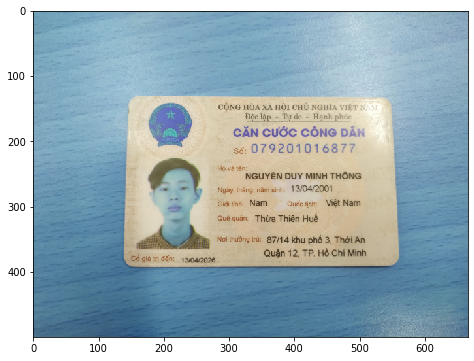

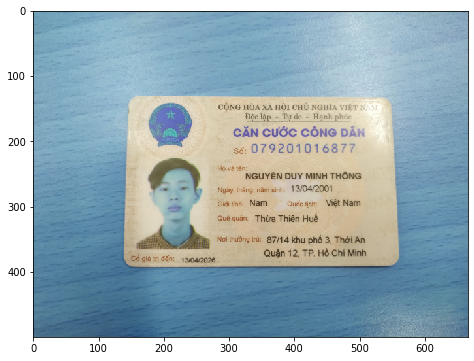

In [5]:
cccd_path = path_cccd + 'NDMT_CCCD.jpg'
img = cv.imread(cccd_path, cv.IMREAD_COLOR)
img_scale = imutils.resize(img, height=500)
show_image(img_scale)

In [6]:
haar_xml = 'pretrained_model/haarcascade_frontalface_default.xml'
# gray = cv2.cvtColor(img_scale, cv2.COLOR_BGR2GRAY)
try:
    faces = cascade_detector(img_scale, xml=haar_xml, scale_factor=1.3, min_neighbors=5)
except:
    print('oops')

In [7]:
rec_images = denote_face(img_scale, faces)

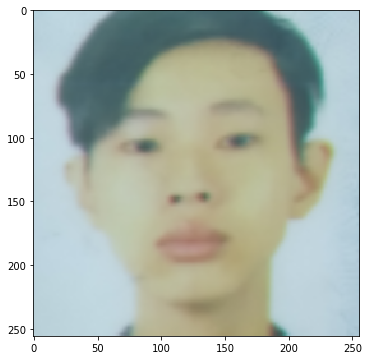

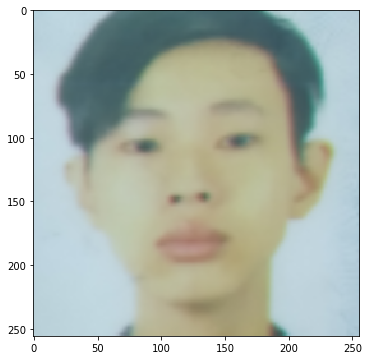

In [8]:
cropped = crop_face(img_scale, faces, scale_factor=1.3, target_size=(256, 256))
show_image(BGR2RGB(cropped))

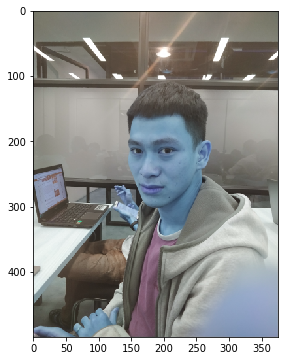

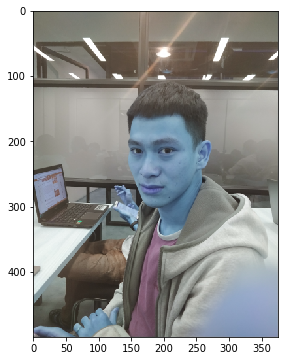

In [9]:
portrait_path = path_facial_verification + 'NPXT_Portrait.jpg'
portrait = cv.imread(portrait_path, cv.IMREAD_COLOR)
portrait_scale = imutils.resize(portrait, height = 500)
show_image(portrait_scale)

In [10]:
try:
    faces_portrait = cascade_detector(portrait_scale, xml=haar_xml, scale_factor=1.1, min_neighbors=9)
except:
    print('oops')

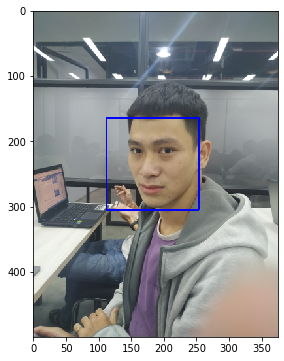

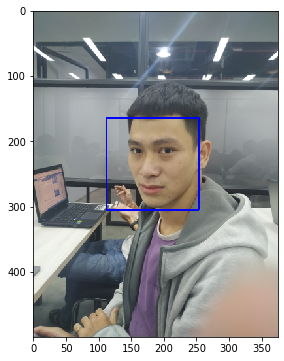

In [11]:
rec_portrait_images = denote_face(portrait_scale, faces_portrait)
show_image(BGR2RGB(rec_portrait_images))

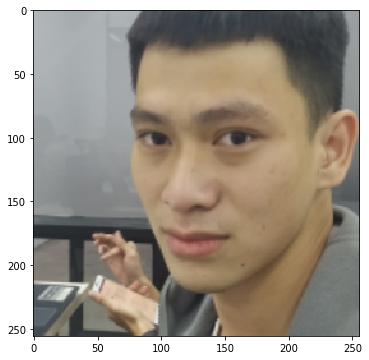

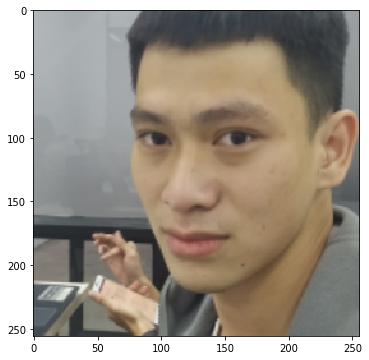

In [12]:
cropped_portrait = crop_face(portrait_scale, faces_portrait, scale_factor=1.3, target_size=(256, 256))
show_image(BGR2RGB(cropped_portrait))

In [13]:
# define path to pre-trained model and haar xml
model_path = 'pretrained_model/facenet-margin-04-final.h5'

# intialize face verification model
face_model = face_verify(path=model_path, xml=haar_xml)

In [14]:
cv.imwrite('scale_cccd.jpg', img_scale)
cv.imwrite('portrait_scale.jpg', portrait_scale)

True

In [15]:
img1, img2, distance = face_model.get_distance('scale_cccd.jpg', 'portrait_scale.jpg')

In [16]:
print(distance)

0.1899041


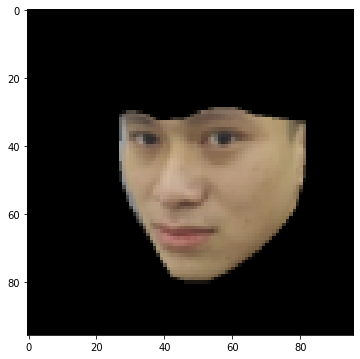

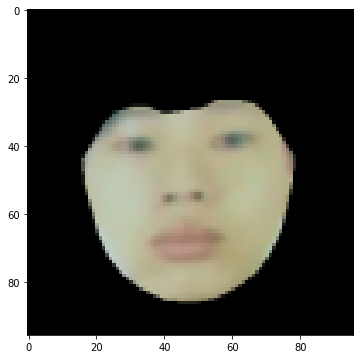

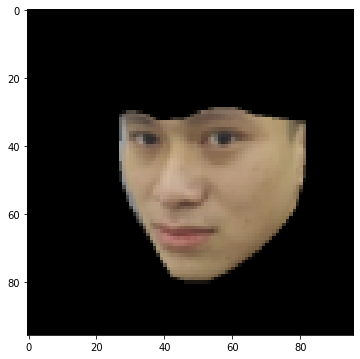

In [17]:
# show_image(img1)
show_image(img2)